# Assignment 1: The Jordan Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Exercise 1: Initializing the network
Consider the Jordan network (with $f(x) = \tanh(x) = (e^x - e^{-x})(e^x + e^{-x})^{-1}$ and $\varphi(x) = \sigma(x) = (1+e^{-x})^{-1}$ and transposed weight matrices compared to the lecture notes)
$$
s(t) = W x(t) + R \hat y(t-1) \\
a(t) = \tanh(s(t)) \\
z(t) = V a(t) \\
\hat y(t) = \sigma(z(t))
$$
for $t \in \mathbb{N}, x(t) \in \mathbb{R}^{D}, s(t) \in \mathbb{R}^{I}, a(t) \in \mathbb{R}^{I}, z(t) \in \mathbb{R}^K, \hat y(t) \in \mathbb{R}^K$ and $W, R, V$ are matrices of appropriate sizes and $\hat y(0) = 0$. 

Write a function `init` that takes a `model` and integers $D, I, K$ as arguments and stores the matrices $W, R, V$ as members `model.W`, `model.R`, `model.V`, respectively. The matrices should be `numpy` arrays of appropriate sizes and filled with random values that are uniformly distributed between -0.01 and 0.01. 

In [2]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid

def tanh(x):
    return(1/((np.exp(x)-np.exp(-x))*(np.exp(x)+np.exp(-x))))

def sigma(z):
    return 1/(1+np.exp(-z))

class Obj(object):
    pass

def init(model, D, I, K): #dunder pls
    model.W = np.random.uniform(low=-0.01,high=0.01,size=(D,I))
    model.R = np.random.uniform(low=-0.01,high=0.01,size=(I))
    model.V = np.random.uniform(low=-0.01,high=0.01,size=(I,K))

    t = 5 #any value of t
    test_x = np.random.uniform(size=(D))
    try:
        model.W.T @ test_x
        model.R.T*tanh(t)
        model.V.T*tanh(t)
    except Exception as e:
        print("Model init fail")
        
Obj.init=init

T, D, I, K = 10, 3, 5, 1

model = Obj()
model.init(D, I, K)
print("W:\n",model.W)
print("R:\n",model.R)
print("V:\n",model.V)


W:
 [[-0.00399088 -0.00216915  0.00311664  0.00128196 -0.00384173]
 [-0.00738732 -0.00549979 -0.00661492  0.00725356 -0.00164437]
 [-0.00468331  0.00220966 -0.00311014 -0.00336296 -0.00089176]]
R:
 [-0.00999651 -0.00403475 -0.00040842  0.00590663 -0.00773346]
V:
 [[-0.00650846]
 [ 0.00261202]
 [ 0.00654857]
 [-0.00657531]
 [-0.00049171]]


## Exercise 2: Numerical stability of the binary cross-entropy loss function

We will use the binary cross-entropy loss function to train our RNN, which is defined as 
$$
L(\hat y, y) = -y \log \hat y - (1-y) \log (1-\hat y) \quad \text{where} \quad \hat y = \sigma(z) = \frac{1}{1+e^{-z}}
$$
is the sigmoid function. Its argument $z$ is called *logit*. For reasons of numerical stability it is better to let the model emit the logit and incorporate the sigmoid function into the loss function. Explain why this is the case and how we can gain numerical stability by combining the two functions into one. *Hint:* Find a numerically stable version of the function $f(z) = \log(1+e^{z})$ and rewrite $L(z,y)$ in terms of $f(z)$. 

## ANSWER

If the model makes a large error st. z is far below zero, the sigmoid function might put out a float that is small enough to become a numerical zero in the execution of the code. This becomes problematic as the sigmoid output is passed to the loss function where the log of $\hat y$ becomes $- \infty$ and thus numerically unstable.
We thus integrate the sigmoidal function into the loss function:

$$
L(z, y) = -y \log ( \frac{1}{1+e^{-z}} ) - (1-y) \log (1-( \frac{1}{1+e^{-z}} )) \quad =
$$
$$
= -y\log(\frac{1}{1 + e^{-z}}) - (1 - y)\log(\frac{e^{-z}}{1 + e^{-z}})\\
= y  \log(1 + e^{-z}) + (1 - y)  (-\log(e^{-z}) + \log(1 + e^{-z}))\\
= y  \log(1 + e^{-z}) + (1 - y)  (z + \log(1 + e^{-z})\\
= (1 - y)  z + \log(1 + e^{-z})\\
= z - z  y + \log(1 + e^{-z})\\
$$

If z is negative and large the output of $e^{-z}$ can cause numerical overflow.
In order to prevent this we can:

$$
  z - zy + \log(1 + e^{-z})\\
= \log(e^{z}) - zy + \log(1 + e^{-z})\\
= - zy + \log(1 + e^{z})\\
$$

or:

$$
= - zy + f(z)\\
$$


## Exercise 3: The forward pass
Write a function `forward` that takes a `model`, a sequence of input vectors $(x(t))_{t=1}^T$, and a label `y` as arguments. The inputs will be represented as a `numpy` array of shape `(T, D)`. It should execute the behavior of the Jordan network and evaluate the numerically stablilized binary cross-entropy loss at the end of the sequence and return the resulting loss value. Store the sequence of hidden activations $(a(t))_{t=1}^T$ and the sequence of logits $(z(t))_{t=1}^T$ into `model.a` and `model.z`, respectively, using the same representation scheme as for the inputs. 

In [6]:
def loss_fn(y_hat,y):
    return -(y*np.log(y_hat)-(1-y)*np.log(1-y_hat))

def forward(self, x, y):
    self.a = [np.zeros(I)]
    self.z = []
    self.y_hat = []
    
    for t,x_t in enumerate(x):#defining t to start at one but keeping a zero-th a makes this tricky
        s = self.W.T@x[t] + self.R.T@self.a[-1]
        self.a.append(tanh(s))
        self.z.append(self.V.T@self.a[-1]) #a[-1] is now the new a
    self.y_hat=list(map(sigma,self.z))
    loss_sequence = np.array([ loss_fn(y_hat[0],y) for y_hat in self.y_hat ])

    return np.average(loss_sequence)
        

Obj.forward = forward
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

17.55812082966621

## Exercise 4: The computational graph

Visualize the functional graph of the Jordan network unfolded in time. The graph should show at least 3 consecutive time steps. Use the package `networkx` in combination with `matplotlib` to draw a directed graph with labelled nodes and edges. If you need help take a look at [this guide](https://networkx.guide/visualization/basics/). Make sure to arrange the nodes in a meaningful way. 

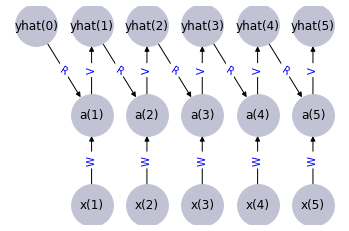

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()
T = 5

positions={}
edge_labels={}
for _ in range(1,T+1):
    G.add_edge(f"yhat({_-1})",f"a({_})")
    positions[f"a({_})"]=[_+1,0]
    edge_labels[(f"yhat({_-1})",f"a({_})")]="R"
    G.add_edge(f"x({_})",f"a({_})")
    positions[f"x({_})"]=[_+1,-1]
    edge_labels[(f"x({_})",f"a({_})")]="W"
    G.add_edge(f"a({_})",f"yhat({_})")
    positions[f"yhat({_-1})"]=[_,+1]
    edge_labels[(f"a({_})",f"yhat({_})")]="V"
              
positions[f"yhat({T})"]=[_+1,+1]    

nx.draw_networkx_edge_labels(G,pos=positions,edge_labels=edge_labels,font_color='blue')

nx.draw(G,with_labels=True,pos=positions,node_size=1750,node_color="#C1C2D4",alpha =1,edge_color='k',linewidths=1)
plt.show()




## Exercise 5: Derivative of the loss

Calculate the derivative of the binary cross-entropy loss function $L(z, y)$ with respect to the logit $z$.

## ANSWER

Binary cross-entropy loss function is
$$
L(z, y) = - zy + f(z)  \quad 
$$
So the derivative with respect to the logit z is
$$
\frac{\partial }{\partial z}L(z,y) = \frac{\partial}{\partial z}\left [- zy + f(z)  \right ] =
$$
$$
\frac{\partial }{\partial z} [ \log(1 + e^{z}) ] - y =
$$
$$
\frac{e^{z}}{1+e^{z}}-y
$$


## Exercise 6: Gradients with respect to network parameters

Compute gradients for the weights of the Jordan network analytically. That is, derive backpropagation through time for the Jordan network. To do this, it is crucial to first find the derivative w.r.t. the network outputs $\psi^\top(t) = \partial L / \partial z(t)$ and hidden pre-activations $\delta^\top(t) = \partial L / \partial s(t)$. We use the shorthand notations $L = \sum_{t=1}^T L(t)$ and $L(t) = L(y(t), \hat y(t))$ for convenience. We use numerator-layout notation for partial derivatives (like in the lecture notes) which lets us multiply the chain rule from left to right. 

Compute the gradients $\psi^\top(t), \delta^\top(t), \nabla_W L, \nabla_R L, \nabla_V L$. *Hint:* Take a look at the  graph from the previous exercise to see the functional dependencies. 

########## YOUR SOLUTION HERE ##########


$\psi^\top(t) = \partial L / \partial z(t) = \frac{\partial L(t)}{\partial \hat y(t)} \frac{\partial \hat y(t)}{\partial z(t)}$ is this the thing I calculated in EX5?
is this the e(t) that is described in the exercise slides?

### For $\nabla_V L$

$\frac{\partial L}{\partial \upsilon_{ik}} = \sum_{t=1}^{T}\frac{\partial L(t)}{\partial \upsilon_{ik}} = \sum_{t=1}^{T}\frac{\partial L(t)}{\partial \hat y(t)}\frac{\partial \hat y(t)}{\partial z(t)} \frac{ \partial  z(t)}{\partial \upsilon_{ik}}$

and with respect to k:

$\sum_{t=1}^{T}\frac{\partial L(t)}{\partial \hat y_{k}(t)}\frac{\partial \hat y_{k}(t)}{\partial z_k(t)} \frac{ \partial  z_k(t)}{\partial \upsilon_{ik}}
$


Now because $z(t) = V a(t)$ and thus $z_{k}(t) = \sum_{i=1}^{I} \upsilon_{ik}a_{i}(t)$ :

$\frac{ \partial  z_k(t)}{\partial \upsilon_{ik}} =  
\sum_{j=1}^{I} \frac {\partial \upsilon_{jk}a_{j}(t)}{\partial \upsilon_{ik}}
=a_{i}(t)$

Thus:

$\frac{\partial L}{\partial \upsilon_{ik}} = \sum_{t=1}^{T}\frac{\partial L(t)}{\partial \hat y_{k}(t)}\frac{\partial \hat y_{k}(t)}{\partial z_k(t)} a_{i}
$

If this is applied to the Matrix $V^{I \times K}$ and $\psi^\top(t) = \partial L / \partial z(t) = \frac{\partial L(t)}{\partial \hat y(t)} \frac{\partial \hat y(t)}{\partial z(t)} = 
\begin{bmatrix}
\frac{\partial L(t)}{\partial \hat y_{1}(t)}\frac{\partial \hat y_{1}(t)}{\partial z_1(t)}
\\ 
\vdots 
\\ 
\frac{\partial L(t)}{\partial \hat y_{K}(t)}\frac{\partial \hat y_{K}(t)}{\partial z_K(t)}
\end{bmatrix}$

$\frac{\partial L}{\partial V} = \nabla_V L = \sum_{t=1}^{T} \psi(t) a(t)^{\top}$


### For $\delta^\top(t)$

The loss that is caused in the future by setting the hidden neurons to a value

$\delta^\top(t) = \partial L / \partial s(t) = \frac {\partial L}{\partial a(t)} \frac{\partial a(t)}{\partial s(t)}$

this is because:

$a(t) = \tanh(s(t))$

then:

$\partial L / \partial s(t) = \left ( \psi(t) \frac {\partial z (t)} {\partial a(t)} + \frac{\partial L}{\partial s(t+1)}\frac{\partial s(t+1)}{\partial a(t)} \right )\frac{\partial a(t)}{\partial s(t)}$


for similar reasons in the case of the first term $\psi(t) \frac {\partial z (t)} {\partial a(t)}$ because of $z(t) = V a(t)$. The term that is dependent on t in $s(t)$ propagates through $a(t)$.

For the term dependent on $t+1$ it is complicated bc. the outcome of $s(t)$ depends on $s(t-1)$. The derivative therefore has to be calculated recursively for all $t \in T $ 

anscheinend $\frac{\partial a(t)}{\partial s(t)} = diag(f{}'(s(t)))$ ?

$\delta(t) = \left( \psi(t) V^{\top} + \delta(t+1)^{\top} R^{\top} \right ) diag(f{}'(s(t)))$

### For R and W


$\frac{\partial L}{ \partial r_{ij}} = \sum_{t=1}^{T} \frac{\partial L}{ \partial r_{ij}(t)}=\sum_{t=1}^{T} \frac{\partial L}{\partial s(t)}\frac{\partial s(t)}{ \partial r_{ij}(t)}$

$= \sum_{t=1}^{T} \frac{\partial L}{\partial s_j(t)}\frac{\partial s_j(t)}{ \partial r_{ij}(t)}
= \sum_{t=1}^{T} \delta_{j}(t) a_{i}(t-1)$

st.

$\nabla_R L = \frac{\partial L}{\partial R} = \sum_{t=1}^{T} \delta(t) a(t-1)$

And similar to R:

$\frac{\partial L}{ \partial \omega_{dj}} = \sum_{t=1}^{T} \delta_{j}(t)x_{d}(t)$

st.

$\nabla_W L = \frac{\partial L}{ \partial W} = \sum_{t=1}^{T} \delta(t)x(t)$



## Exercise 7: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `model.dW`, `model.dR`, `model.dV`, respectively. 

In [ ]:
def backward(self):
    ########## YOUR SOLUTION HERE ##########
    self.psi = 
    self.delta = 
    
    self.dV = 
    
    
Obj.backward = backward
model.backward()

## Exercise 8: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error. 

In [ ]:
def grad_check(self, eps, thresh):
    ########## YOUR SOLUTION HERE ##########

Obj.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

## Exercise 9: Parameter update

Write a function `update` that takes a `model` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [ ]:
def update(self, eta):
    ########## YOUR SOLUTION HERE ##########

Obj.update = update
model.update(0.001)

## Exercise 10: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ are generated by a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the Python generator pattern and produce data in the way described above. The input sequences should have shape `(T, 1)` and the target values should have shape `(1,)`.

In [ ]:
def generate_data(T):
    ########## YOUR SOLUTION HERE ##########

data = generate_data(2)

## Exercise 11: Network training

Train a Jordan network with 32 hidden units. Start with input sequences of length one and tune the leraning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the Jordan network can achieve a performance that is better than random? Visualize your results. 

In [ ]:
########## YOUR SOLUTION HERE ##########